# Predicting p-factor from EEG - Example

The code below provides an example of using the *braindecode* and *EEGDash* libraries in combination with LightGBM to predict a subject's p-factor.

1. **Data Retrieval Using EEGDash**: An instance of *EEGDashDataset* is created to search and retrieve resting state data. At this step, only the metadata is transferred.

2. **Data Preprocessing Using BrainDecode**: This process preprocesses EEG data using Braindecode by selecting specific channels, resampling, filtering, and extracting 10-second epochs.

3. **Extracting EEG Features Using EEGDash.features**: Building a feature extraction tree and extracting features per EEG window.

4. **Model Training and Evaluation Process**: This section normalizes input data, trains a LightGBM model, and evaluates regression MSE.

## Data Retrieval Using EEGDash

In [1]:
from eegdash import EEGDashDataset

# hbn_datasets_train = ['ds005505', 'ds005506', 'ds005507', 'ds005508', 'ds005510', 'ds005511', 'ds005512', 'ds005514', 'ds005515', 'ds005516']
hbn_datasets_train = ["ds005505", "ds005506", "ds005507"]
hbn_datasets_valid = ["ds005509"]
desc_fields = ["subject", "session", "run", "task", "age", "gender", "sex", "p_factor"]
task_name = "RestingState"
target_name = "p_factor"

datasets_train = [
    EEGDashDataset(
        {"dataset": ds, "task": task_name},
        description_fields=desc_fields,
        target_name=target_name,
    )
    for ds in hbn_datasets_train
]
datasets_valid = [
    EEGDashDataset(
        {"dataset": ds, "task": task_name},
        description_fields=desc_fields,
        target_name=target_name,
    )
    for ds in hbn_datasets_valid
]

In [2]:
from braindecode.datasets import BaseConcatDataset

raw_train = BaseConcatDataset(
    [ds for dataset in datasets_train for ds in dataset.datasets]
)
raw_valid = BaseConcatDataset(
    [ds for dataset in datasets_valid for ds in dataset.datasets]
)

## Data Preprocessing Using Braindecode

[BrainDecode](https://braindecode.org/stable/install/install.html) is a specialized library for preprocessing EEG and MEG data. 

We apply three preprocessing steps in Braindecode:
1.	**Selection** of 24 specific EEG channels from the original 128.
2.	**Resampling** the EEG data to a frequency of 128 Hz.
3.	**Filtering** the EEG signals to retain frequencies between 1 Hz and 55 Hz.

When calling the **preprocess** function, the data is retrieved from the remote repository.

Finally, we use **create_windows_from_events** to extract 10-second epochs from the data. These epochs serve as the dataset samples.

In [3]:
import os
from braindecode.preprocessing import (
    preprocess,
    Preprocessor,
    create_fixed_length_windows,
)


def preprocess_and_window(raw_ds):
    # preprocessing using a Braindecode pipeline:
    preprocessors = [
        Preprocessor(
            "pick_channels",
            ch_names=[
                "E22",
                "E9",
                "E33",
                "E24",
                "E11",
                "E124",
                "E122",
                "E29",
                "E6",
                "E111",
                "E45",
                "E36",
                "E104",
                "E108",
                "E42",
                "E55",
                "E93",
                "E58",
                "E52",
                "E62",
                "E92",
                "E96",
                "E70",
                "Cz",
            ],
        ),
        Preprocessor("resample", sfreq=128),
        Preprocessor("filter", l_freq=1, h_freq=55),
    ]
    preprocess(raw_ds, preprocessors, n_jobs=-1)

    # extract windows and save to disk
    sfreq = raw_ds.datasets[0].raw.info["sfreq"]
    windows_ds = create_fixed_length_windows(
        raw_ds,
        start_offset_samples=0,
        stop_offset_samples=None,
        window_size_samples=int(10 * sfreq),
        window_stride_samples=int(5 * sfreq),
        drop_last_window=True,
        preload=False,
    )
    return windows_ds


windows_train = preprocess_and_window(raw_train)
os.makedirs(f"data/hbn_preprocessed_{task_name}_train", exist_ok=True)
windows_train.save(f"data/hbn_preprocessed_{task_name}_train", overwrite=True)

windows_valid = preprocess_and_window(raw_valid)
os.makedirs(f"data/hbn_preprocessed_{task_name}_valid", exist_ok=True)
windows_valid.save(f"data/hbn_preprocessed_{task_name}_valid", overwrite=True)

Writing c:\Users\aviv_\Dropbox\Research\EEG-DaSh\EEGDash\notebooks\data\hbn_preprocessed_RestingState_train\0\0-raw.fif
Closing c:\Users\aviv_\Dropbox\Research\EEG-DaSh\EEGDash\notebooks\data\hbn_preprocessed_RestingState_train\0\0-raw.fif
[done]
Writing c:\Users\aviv_\Dropbox\Research\EEG-DaSh\EEGDash\notebooks\data\hbn_preprocessed_RestingState_train\1\1-raw.fif
Closing c:\Users\aviv_\Dropbox\Research\EEG-DaSh\EEGDash\notebooks\data\hbn_preprocessed_RestingState_train\1\1-raw.fif
[done]
Writing c:\Users\aviv_\Dropbox\Research\EEG-DaSh\EEGDash\notebooks\data\hbn_preprocessed_RestingState_train\2\2-raw.fif
Closing c:\Users\aviv_\Dropbox\Research\EEG-DaSh\EEGDash\notebooks\data\hbn_preprocessed_RestingState_train\2\2-raw.fif
[done]
Writing c:\Users\aviv_\Dropbox\Research\EEG-DaSh\EEGDash\notebooks\data\hbn_preprocessed_RestingState_train\3\3-raw.fif
Closing c:\Users\aviv_\Dropbox\Research\EEG-DaSh\EEGDash\notebooks\data\hbn_preprocessed_RestingState_train\3\3-raw.fif
[done]
Writing c:\U

c:\Users\aviv_\.virtualenvs\EEGDash-f5ZEn2Ga\Lib\site-packages\braindecode\datasets\base.py:700: UserWarning: The number of saved datasets (329) does not match the number of existing subdirectories (470). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
c:\Users\aviv_\.virtualenvs\EEGDash-f5ZEn2Ga\Lib\site-packages\braindecode\datasets\base.py:708: UserWarning: Chosen directory data/hbn_preprocessed_RestingState_valid contains other subdirectories or files ['329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393',

## Extracting EEG Features Using EEGDash.features

In [4]:
from eegdash import features
from eegdash.features import extract_features
from functools import partial

sfreq = windows_train.datasets[0].raw.info["sfreq"]
filter_freqs = dict(windows_train.datasets[0].raw_preproc_kwargs)["filter"]
features_dict = {
    "sig": features.FeatureExtractor(
        {
            "std": features.signal_std,
            "line_len": features.signal_line_length,
            "zero_x": features.signal_zero_crossings,
        },
    ),
    "spec": features.SpectralFeatureExtractor(
        {
            "rtot_power": features.spectral_root_total_power,
            "band_power": features.spectral_bands_power,
            0: features.NormalizedSpectralFeatureExtractor(
                {
                    "moment": features.spectral_moment,
                    "entropy": features.spectral_entropy,
                    "edge": partial(features.spectral_edge, edge=0.9),
                },
            ),
            1: features.DBSpectralFeatureExtractor(
                {
                    "slope": features.spectral_slope,
                },
            ),
        },
        fs=sfreq,
        f_min=filter_freqs["l_freq"],
        f_max=filter_freqs["h_freq"],
        nperseg=4 * sfreq,
        noverlap=3 * sfreq,
    ),
}

features_train = extract_features(
    windows_train, features_dict, batch_size=64, n_jobs=-1
)
os.makedirs(f"data/hbn_features_{task_name}_train", exist_ok=True)
features_train.save(f"data/hbn_features_{task_name}_train", overwrite=True)

features_valid = extract_features(
    windows_valid, features_dict, batch_size=64, n_jobs=-1
)
os.makedirs(f"data/hbn_features_{task_name}_valid", exist_ok=True)
features_valid.save(f"data/hbn_features_{task_name}_valid", overwrite=True)

Extracting features: 100%|██████████| 329/329 [00:14<00:00, 22.72it/s]


In [5]:
features_train.to_dataframe()

,sig_std_E22,sig_std_E9,sig_std_E33,sig_std_E24,sig_std_E11,sig_std_E124,sig_std_E122,sig_std_E29,sig_std_E6,sig_std_E111,...,spec_slope_int_E42,spec_slope_int_E55,spec_slope_int_E93,spec_slope_int_E58,spec_slope_int_E52,spec_slope_int_E62,spec_slope_int_E92,spec_slope_int_E96,spec_slope_int_E70,spec_slope_int_Cz
0,0.000048,0.000046,0.000040,0.000038,0.000036,0.000041,0.000041,0.000034,0.000013,0.000039,...,-110.954724,-121.265501,-110.078414,-110.766717,-111.096595,-118.720779,-109.998462,-108.275599,-112.537442,-150.0
1,0.000038,0.000035,0.000031,0.000030,0.000028,0.000033,0.000032,0.000027,0.000011,0.000031,...,-110.135751,-128.914312,-111.979279,-111.496639,-110.958982,-113.463232,-111.478475,-106.279726,-111.113442,-150.0
2,0.000038,0.000035,0.000031,0.000030,0.000028,0.000033,0.000033,0.000027,0.000011,0.000031,...,-110.550067,-129.395116,-108.367819,-111.386865,-110.763626,-114.441078,-108.365344,-104.034827,-112.007315,-150.0
3,0.000040,0.000039,0.000032,0.000030,0.000029,0.000034,0.000033,0.000027,0.000011,0.000032,...,-109.543879,-127.620586,-107.678189,-110.151366,-109.686855,-112.262193,-108.246371,-104.956875,-110.893519,-150.0
4,0.000040,0.000039,0.000032,0.000030,0.000029,0.000034,0.000033,0.000028,0.000011,0.000032,...,-110.076806,-128.476583,-107.956610,-109.702324,-109.915481,-113.672833,-107.866612,-104.357844,-110.888243,-150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39801,0.000031,0.000027,0.000037,0.000019,0.000027,0.000015,0.000024,0.000015,0.000005,0.000012,...,-103.577504,-106.776289,-103.601516,-95.602532,-103.133437,-91.296651,-98.730994,-93.870435,-87.781822,-150.0
39802,0.000192,0.000130,0.000097,0.000139,0.000048,0.000037,0.000052,0.000047,0.000006,0.000020,...,-106.054060,-104.926996,-106.695355,-98.163812,-105.639347,-92.954297,-101.751442,-96.768477,-89.980306,-150.0
39803,0.000194,0.000132,0.000093,0.000140,0.000047,0.000038,0.000051,0.000047,0.000007,0.000022,...,-106.649073,-105.277464,-106.456313,-100.290716,-105.743187,-93.804706,-101.695959,-97.320982,-92.102674,-150.0
39804,0.000048,0.000041,0.000029,0.000028,0.000027,0.000019,0.000030,0.000016,0.000006,0.000014,...,-96.612690,-107.623632,-97.603472,-94.961150,-95.526898,-97.379095,-94.883547,-98.273056,-95.738855,-150.0


Replace Inf and NaN values:

In [6]:
import numpy as np

features_train.replace([-np.inf, +np.inf], np.nan)
features_train.fillna(0)

features_valid.replace([-np.inf, +np.inf], np.nan)
features_valid.fillna(0)

In [7]:
features_train.to_dataframe()

,sig_std_E22,sig_std_E9,sig_std_E33,sig_std_E24,sig_std_E11,sig_std_E124,sig_std_E122,sig_std_E29,sig_std_E6,sig_std_E111,...,spec_slope_int_E42,spec_slope_int_E55,spec_slope_int_E93,spec_slope_int_E58,spec_slope_int_E52,spec_slope_int_E62,spec_slope_int_E92,spec_slope_int_E96,spec_slope_int_E70,spec_slope_int_Cz
0,0.000048,0.000046,0.000040,0.000038,0.000036,0.000041,0.000041,0.000034,0.000013,0.000039,...,-110.954724,-121.265501,-110.078414,-110.766717,-111.096595,-118.720779,-109.998462,-108.275599,-112.537442,-150.0
1,0.000038,0.000035,0.000031,0.000030,0.000028,0.000033,0.000032,0.000027,0.000011,0.000031,...,-110.135751,-128.914312,-111.979279,-111.496639,-110.958982,-113.463232,-111.478475,-106.279726,-111.113442,-150.0
2,0.000038,0.000035,0.000031,0.000030,0.000028,0.000033,0.000033,0.000027,0.000011,0.000031,...,-110.550067,-129.395116,-108.367819,-111.386865,-110.763626,-114.441078,-108.365344,-104.034827,-112.007315,-150.0
3,0.000040,0.000039,0.000032,0.000030,0.000029,0.000034,0.000033,0.000027,0.000011,0.000032,...,-109.543879,-127.620586,-107.678189,-110.151366,-109.686855,-112.262193,-108.246371,-104.956875,-110.893519,-150.0
4,0.000040,0.000039,0.000032,0.000030,0.000029,0.000034,0.000033,0.000028,0.000011,0.000032,...,-110.076806,-128.476583,-107.956610,-109.702324,-109.915481,-113.672833,-107.866612,-104.357844,-110.888243,-150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39801,0.000031,0.000027,0.000037,0.000019,0.000027,0.000015,0.000024,0.000015,0.000005,0.000012,...,-103.577504,-106.776289,-103.601516,-95.602532,-103.133437,-91.296651,-98.730994,-93.870435,-87.781822,-150.0
39802,0.000192,0.000130,0.000097,0.000139,0.000048,0.000037,0.000052,0.000047,0.000006,0.000020,...,-106.054060,-104.926996,-106.695355,-98.163812,-105.639347,-92.954297,-101.751442,-96.768477,-89.980306,-150.0
39803,0.000194,0.000132,0.000093,0.000140,0.000047,0.000038,0.000051,0.000047,0.000007,0.000022,...,-106.649073,-105.277464,-106.456313,-100.290716,-105.743187,-93.804706,-101.695959,-97.320982,-92.102674,-150.0
39804,0.000048,0.000041,0.000029,0.000028,0.000027,0.000019,0.000030,0.000016,0.000006,0.000014,...,-96.612690,-107.623632,-97.603472,-94.961150,-95.526898,-97.379095,-94.883547,-98.273056,-95.738855,-150.0


## Model Training and Evaluation

Convert to pandas dataframes and normalize:

In [8]:
mean_train = features_train.mean(n_jobs=-1)
std_train = features_train.std(eps=1e-14, n_jobs=-1)

X_train = features_train.to_dataframe()
X_train = (X_train - mean_train) / std_train
y_train = features_train.get_metadata()["target"]

X_valid = features_valid.to_dataframe()
X_valid = (X_valid - mean_train) / std_train
y_valid = features_valid.get_metadata()["target"]

### Train

In [9]:
from lightgbm import LGBMRegressor, record_evaluation

random_seed = 137

model = LGBMRegressor(
    random_state=random_seed,
    n_jobs=-1,
    n_estimators=10000,
    num_leaves=5,
    max_depth=2,
    min_data_in_leaf=4,
    learning_rate=0.1,
    early_stopping_round=5,
    first_metric_only=True,
)

eval_results = dict()
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_names=["train", "validation"],
    eval_metric="l2",
    callbacks=[record_evaluation(eval_results)],
)

y_hat_train = model.predict(X_train)
correct_train = ((y_train - y_hat_train) ** 2).mean()
y_hat_valid = model.predict(X_valid)
correct_valid = ((y_valid - y_hat_valid) ** 2).mean()
print(f"Train MSE: {correct_train:.2f}, Validation MSE: {correct_valid:.2f}\n")

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75193
[LightGBM] [Info] Number of data points in the train set: 39806, number of used features: 300
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Info] Start training from score 0.046996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

### Plot Results

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

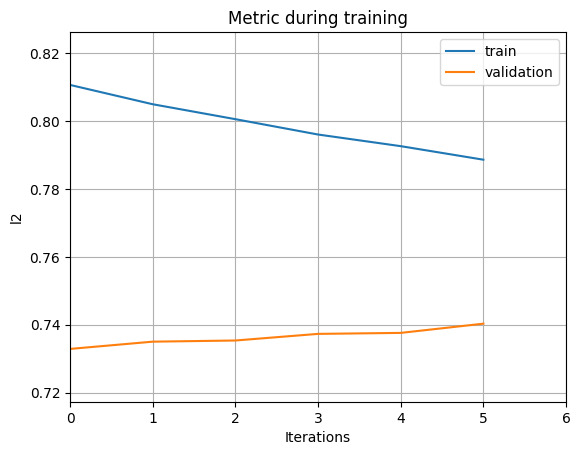

In [10]:
from lightgbm import plot_metric

plot_metric(model, "l2")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

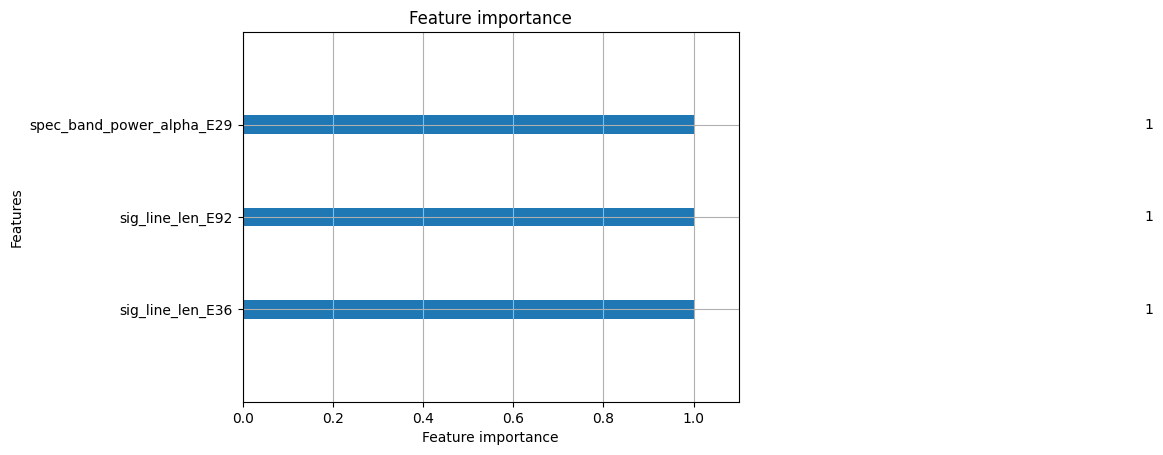

In [11]:
from lightgbm import plot_importance

plot_importance(model, importance_type="split", max_num_features=10)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

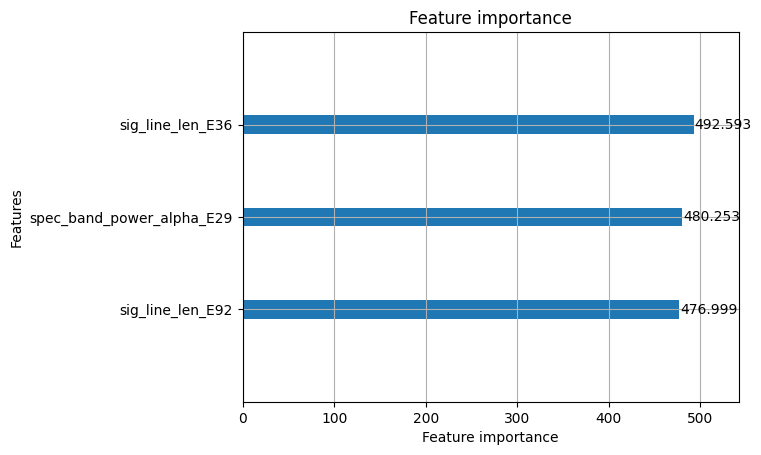

In [12]:
plot_importance(model, importance_type="gain", max_num_features=10)